In [0]:
#
# Part A Qn 1
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle



NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 2000
batch_size = 128


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    no_of_patterns = labels.shape[0]
    
    # one hot encoding of labels
    # labels ranging from 0 to 9
    labels_onehot = np.zeros([no_of_patterns, NUM_CLASSES])
    labels_onehot[np.arange(no_of_patterns), labels] = 1

    return data, labels_onehot



def cnn(images):

    # channel first RGB images
    images = tf.reshape(images, [-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE])
    # convert to channel last
    images = tf.transpose(images, perm=[0,2,3,1])
    
    # Conv 1
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, 50], 
                                         stddev = 1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)), 
                     name='weights_1')
    b1 = tf.Variable(tf.zeros([50]), name='biases_1')
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)

    # Pool 1
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_1')

    # Conv 2
    W2 = tf.Variable(tf.truncated_normal([5, 5, 50, 60], stddev = 1.0 / np.sqrt(50 * 5 * 5)), 
                     name='weights_2')
    b2 = tf.Variable(tf.zeros([60]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)

    # Pool 2
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_2')
    # Flatten
    print('shape at pool_2:', pool_2.shape)
    dim = pool_2.shape[1].value * pool_2.shape[2].value * pool_2.shape[3].value
    pool_2_flat = tf.reshape(pool_2, [-1, dim])
	
    # Fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), 
                        name='weights_fc1')
    b_fc1 = tf.Variable(tf.zeros([300]), name='biases_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc1) + b_fc1)

    # Softmax
    W_fc2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), 
                        name='weights_fc2')
    b_fc2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_fc2')
    logits = tf.matmul(h_fc1, W_fc2) + b_fc2

    return conv_1, pool_1, conv_2, pool_2, logits


In [0]:
# Load in data

trainX, trainY = load_data('data_batch_1')
print('Training data shape:', trainX.shape, trainY.shape)

testX, testY = load_data('test_batch_trim')
print('Test data shape:', testX.shape, testY.shape)

# Scale the images
min_trainX = np.min(trainX, axis = 0)
max_trainX = np.max(trainX, axis = 0)
trainX = (trainX - min_trainX) / max_trainX
testX = (testX - min_trainX) / max_trainX

Training data shape: (10000, 3072) (10000, 10)
Test data shape: (2000, 3072) (2000, 10)


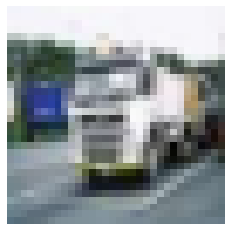

In [0]:
# Visualise the data
# The documentation writes: The first 1024 entries contain the red channel values, the next 1024 
# the green, and the final 1024 the blue. Hence, reshape to (NUM_CHANNELS, IMG_SIZE, IMG_SIZE).
X = trainX[1000].reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE)

plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(X.transpose(1,2,0))

In [0]:
# Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

conv_1, pool_1, conv_2, pool_2, logits = cnn(x)

# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Optimiser
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)


shape at pool_2: (?, 4, 4, 60)


iter 0 --- train cost: 2.3020911 , test accuracy: 0.099
iter 100 --- train cost: 1.7796898 , test accuracy: 0.3635
iter 200 --- train cost: 1.5209724 , test accuracy: 0.4355
iter 300 --- train cost: 1.3975937 , test accuracy: 0.4865
iter 400 --- train cost: 1.2759575 , test accuracy: 0.516
iter 500 --- train cost: 1.1677465 , test accuracy: 0.5345
iter 600 --- train cost: 1.1140853 , test accuracy: 0.538
iter 700 --- train cost: 1.0022594 , test accuracy: 0.5555
iter 800 --- train cost: 0.89584005 , test accuracy: 0.5705
iter 900 --- train cost: 0.7922443 , test accuracy: 0.583
iter 1000 --- train cost: 0.7081723 , test accuracy: 0.5675
iter 1100 --- train cost: 0.6122294 , test accuracy: 0.5695
iter 1200 --- train cost: 0.51102424 , test accuracy: 0.576
iter 1300 --- train cost: 0.431466 , test accuracy: 0.5645
iter 1400 --- train cost: 0.36794794 , test accuracy: 0.559
iter 1500 --- train cost: 0.2587227 , test accuracy: 0.5655
iter 1600 --- train cost: 0.1923744 , test accuracy: 0.5

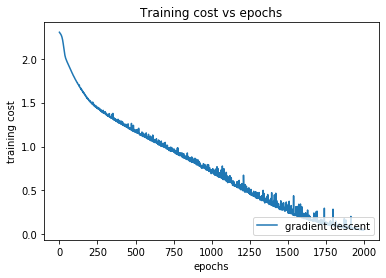

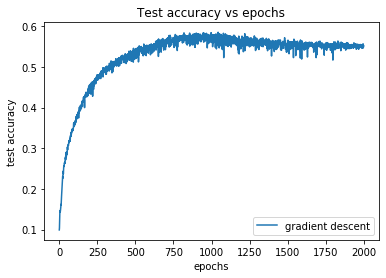

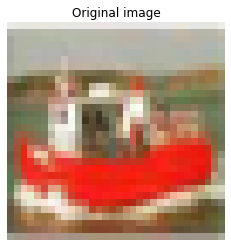

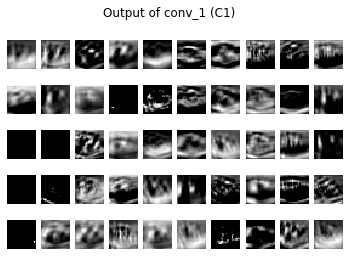

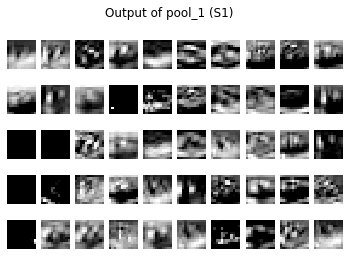

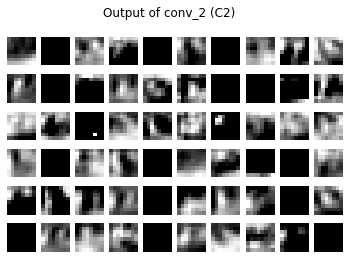

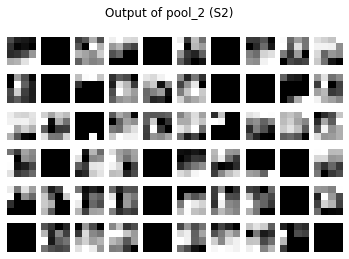

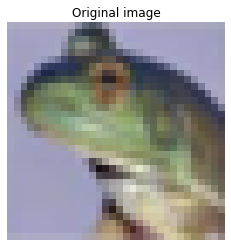

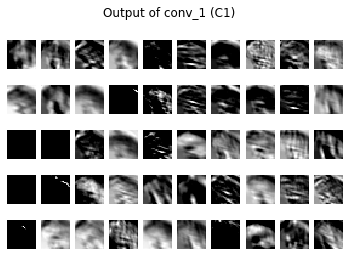

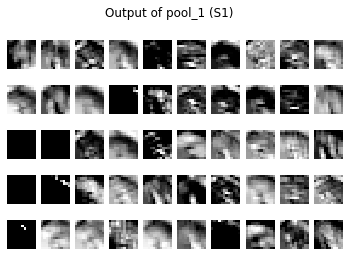

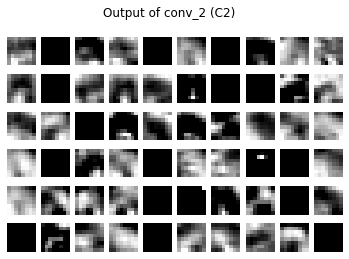

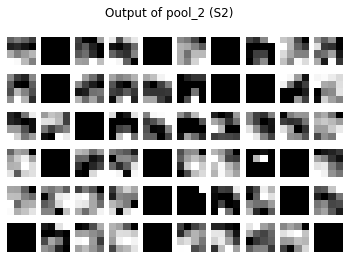

In [0]:
# Training

N = len(trainX)
idx = np.arange(N)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    train_loss = []
    test_acc = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]
        
        # Mini batch learning
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))

        if e % 100 == 0:
            print('iter', e, '--- train cost:', train_loss[e], ', test accuracy:', test_acc[e])

    # Plot learning curve
    plt.figure()
    plt.plot(np.arange(epochs), train_loss, label='gradient descent')
    plt.title('Training cost vs epochs')
    plt.xlabel('epochs')
    plt.ylabel('training cost')
    plt.legend(loc='lower right')

    plt.figure()
    plt.plot(np.arange(epochs), test_acc, label='gradient descent')
    plt.title('Test accuracy vs epochs')
    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.legend(loc='lower right')

    # Visualise 2 random test images
    for image_no in range(2):
        ind = np.random.randint(low=0, high=2000)
        #print('test image index', ind)
        X = testX[ind,:]

        # Original image
        plt.figure()
        plt.gray()
        plt.axis('off')
        plt.title('Original image')
        plt.imshow(X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1,2,0))

        conv_1_, pool_1_, conv_2_, pool_2_ = sess.run([conv_1, pool_1, conv_2, pool_2],
                                                      {x: X.reshape(1, IMG_SIZE * IMG_SIZE * NUM_CHANNELS)})
        # Plot output of conv_1 for the image
        plt.figure()
        plt.gray()
        plt.suptitle('Output of conv_1 (C1)')
        conv_1_ = np.array(conv_1_)
        for i in range(50):
            plt.subplot(5, 10, i+1); plt.axis('off'); plt.imshow(conv_1_[0,:,:,i])

        # Plot output of pool_1 for the image
        plt.figure()
        plt.gray()
        plt.suptitle('Output of pool_1 (S1)')
        pool_1_ = np.array(pool_1_)
        for i in range(50):
            plt.subplot(5, 10, i+1); plt.axis('off'); plt.imshow(pool_1_[0,:,:,i])
        
        # Plot output of conv_2 for the image
        plt.figure()
        plt.gray()
        plt.suptitle('Output of conv_2 (C2)')
        conv_2_ = np.array(conv_2_)
        for i in range(60):
            plt.subplot(6, 10, i+1); plt.axis('off'); plt.imshow(conv_2_[0,:,:,i])

        # Plot output of pool_2 for the image
        plt.figure()
        plt.gray()
        plt.suptitle('Output of pool_2 (S2)')
        pool_2_ = np.array(pool_2_)
        for i in range(60):
            plt.subplot(6, 10, i+1); plt.axis('off'); plt.imshow(pool_2_[0,:,:,i])

        plt.show()


In [0]:
# Save the best model selected for comparison later
train_loss_np = np.array(train_loss)
np.save('Qn1 train loss.npy',train_loss_np)

test_acc_np = np.array(test_acc)
np.save('Qn1 test acc.npy',test_acc_np)